In [86]:
import numpy as np


def distance(p1, p2):
    """Returns the distance between two points p1 and p2"""
    return np.sqrt(np.sum((p1 - p2)**2))

In [87]:
import scipy.stats as ss
import random


def majority_vote(votes):
    """Returns majority vote and its count in a list of votes"""
    vote_counts = {}
    for vote in votes:
        if vote in vote_counts:
            vote_counts[vote] += 1
        else:
            vote_counts[vote] = 1
    winners = []
    max_counts = max(vote_counts.values())
    for vote, count in vote_counts.items():
        if count == max_counts:
            winners.append(vote)
    return random.choice(winners)


def majority_vote_short(votes):
    """Returns majority vote and its count in a list of votes"""
    mode, count = ss.mstats.mode(votes)
    return mode, count

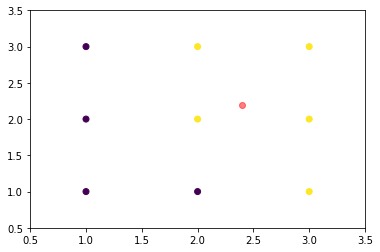

In [88]:
import matplotlib.pyplot as plt
# Point to find the distance from
point = np.array([2.4, 2.2])
# Toy data points
points = np.array([[1, 1], [1, 2], [1, 3], [2, 1], [2, 2], [2, 3], [3, 1],
                   [3, 2], [3, 3]])
# Labels of the correspoinding points
labels = np.array([*np.zeros((4, ), dtype=int), *np.ones((5, ), dtype=int)])

plt.scatter(points[:, 0], points[:, 1], c=labels)
plt.plot(point[0], point[1], "ro", alpha=0.5)
plt.xlim(0.5, 3.5)
plt.ylim(0.5, 3.5)
plt.show()

In [89]:
def knn_predict(point, points, labels, k=5):
    """Returns the predicted label of the point"""
    distances = np.zeros(points.shape[0])
    for i in range(len(distances)):
        distances[i] = distance(point, points[i])
    ind = np.argsort(distances)
    return majority_vote(labels[ind][:k])

In [90]:
def synth_data(n=50):
    """Returns 2n bivariate random variates and labels """
    labels = np.concatenate((np.repeat(0, n), np.repeat(1, n)))
    points = np.concatenate((ss.norm(0, 1).rvs((n, 2)), ss.norm(1, 1).rvs(
        (n, 2))),
                            axis=0)
    return points, labels

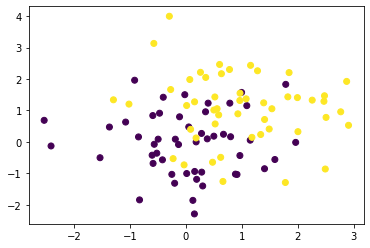

In [91]:
# Sample generator testing
points, labels = synth_data()
plt.scatter(points[:, 0], points[:, 1], c = labels)
plt.show()

In [132]:
# Prediction Grid
def make_prediction_grid(limits, points, labels, k):
    """Returns coordinates of meshgrid and prediction_grid"""
    x_min, x_max, y_min, y_max, h = limits
    xs = np.arange(x_min, x_max, h)
    ys = np.arange(y_min, y_max, h)
    (xx, yy) = np.meshgrid(xs, ys)
    prediction_grid = np.zeros(xx.shape, dtype=int)

    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            prediction_grid[j, i] = knn_predict([x, y], points, labels, k)

    return xx, yy, prediction_grid

In [133]:
def annotate(ax, xlab="X", ylab="Y", title="Figure", ticks=False):
    """Annotates a figure, ticks = tuple with xticks and yticks or a boolean"""
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    if not ticks:
        ax.set_xticks(())
        ax.set_yticks(())

def plot_prediction_grid(xx,
                         yy,
                         prediction_grid,
                         filename,
                         points,
                         labels,
                         xlab,
                         ylab,
                         title,
                         ticks=False):
    """ Plot KNN predictions for every point on the grid."""
    from matplotlib.colors import ListedColormap
    background_colormap = ListedColormap(
        ["lightpink", "lightskyblue", "yellowgreen"])
    observation_colormap = ListedColormap(["red", "blue", "green"])
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.pcolormesh(xx,
                  yy,
                  prediction_grid,
                  cmap=background_colormap,
                  alpha=0.5,
                  shading="auto",
                  antialiased=True)
    ax.scatter(points[:, 0],
               points[:, 1],
               c=labels,
               cmap=observation_colormap,
               s=50)
    annotate(ax, xlab, ylab, title, ticks)
    ax.set_xlim(np.min(xx), np.max(xx))
    ax.set_ylim(np.min(yy), np.max(yy))
    fig.savefig(filename)

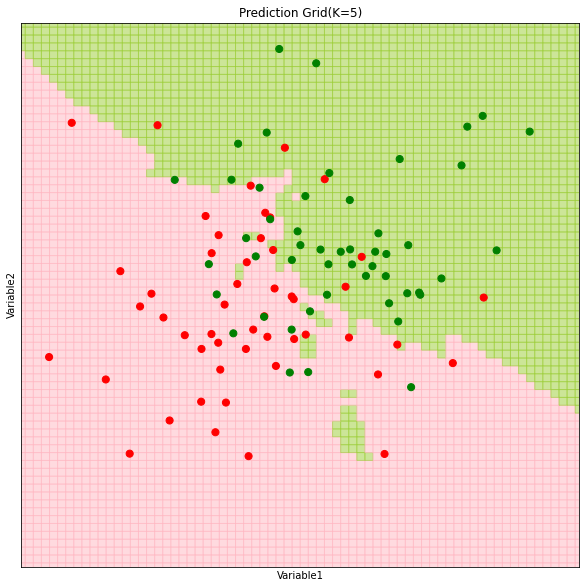

In [134]:
points, labels = synth_data()
limits = (-3, 4, -3, 4, 0.1)
k = 5
xx, yy, prediction_grid = make_prediction_grid(
    limits,
    points,
    labels,
    k,
)
plot_prediction_grid(xx,
                     yy,
                     prediction_grid,
                     "knn_prediction_grid_5.pdf",
                     points=points,
                     labels=labels,
                     xlab="Variable1",
                     ylab="Variable2",
                     title="Prediction Grid(K=5)")

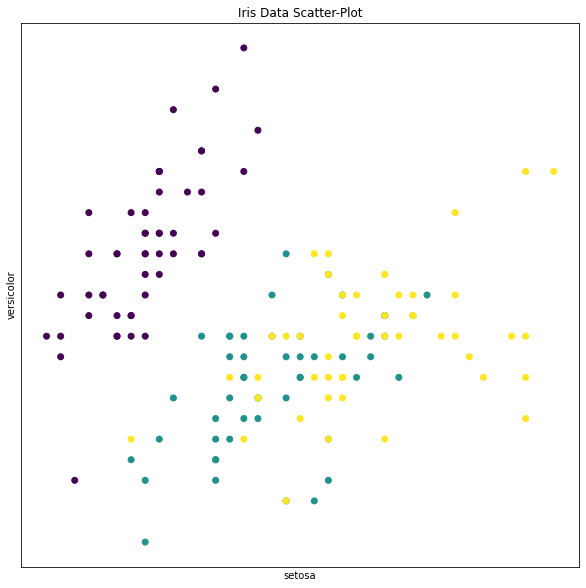

In [135]:
# Load Iris dataset from sklearn
from sklearn import datasets
iris = datasets.load_iris()
predictors = iris.data[:, :2]
labels = iris.target
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(predictors[:, 0], predictors[:, 1], c=labels)
annotate(ax,
         xlab=iris['target_names'][0],
         ylab=iris['target_names'][1],
         title="Iris Data Scatter-Plot")
fig.savefig("Iris_scatter.pdf")

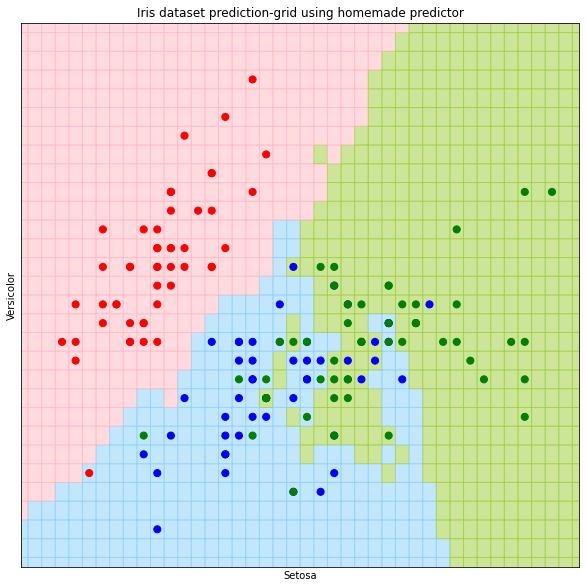

In [137]:
limits = (4, 8.2, 1.8, 4.7, 0.1)
xx, yy, prediction_grid = make_prediction_grid(limits, predictors, labels, k=5)
plot_prediction_grid(xx,
                     yy,
                     prediction_grid,
                     "Iris_grid_homemade.pdf",
                     points=predictors,
                     labels=labels,
                     xlab=iris['target_names'][0].capitalize(),
                     ylab=iris['target_names'][1].capitalize(),
                     title="Iris dataset prediction-grid using homemade predictor")

In [119]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(predictors, labels)
sk_predictions = knn.predict(predictors)
my_predictions = np.array([knn_predict(point, predictors, labels) for point in predictors])
sum(labels == my_predictions) / sk_predictions.shape

array([0.84666667])

In [127]:
# Prediction Grid using sklearn knn.predict function
def make_prediction_grid_sklearn(limits, points, labels, k):
    """Returns coordinates of meshgrid and prediction_grid"""
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(points, labels)
    x_min, x_max, y_min, y_max, h = limits
    xs = np.arange(x_min, x_max, h)
    ys = np.arange(y_min, y_max, h)
    (xx, yy) = np.meshgrid(xs, ys)
    prediction_grid = np.zeros(xx.shape, dtype=int)

    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            prediction_grid[j, i] = knn.predict(np.array([x, y]).reshape(1,-1))

    return xx, yy, prediction_grid

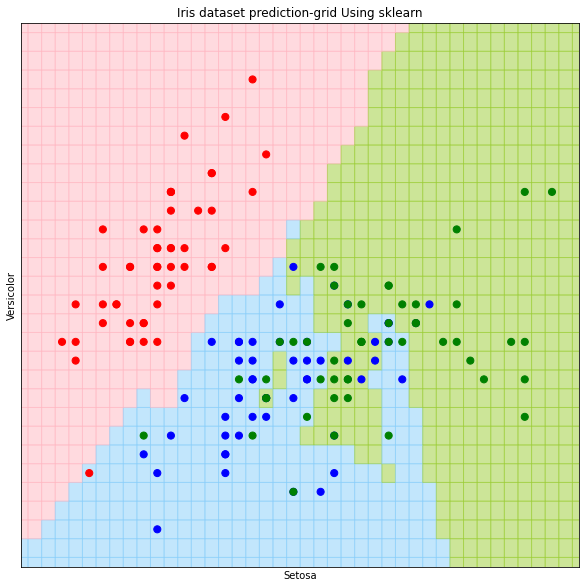

In [130]:
limits = (4, 8.2, 1.8, 4.7, 0.1)
xx, yy, prediction_grid = make_prediction_grid_sklearn(limits, predictors, labels, k=5)
plot_prediction_grid(xx,
                     yy,
                     prediction_grid,
                     "Iris_grid_sklearn.pdf",
                     points=predictors,
                     labels=labels,
                     xlab=iris['target_names'][0].capitalize(),
                     ylab=iris['target_names'][1].capitalize(),
                     title="Iris dataset prediction-grid Using sklearn")